In [64]:
# Web scraping libraries
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import shutil
from get_aggregated_data import *
# Data
import pandas as pd
from SingleTeam import SingleTeamCorners
import numpy as np
import requests
from io import StringIO
import math
# Web app
import streamlit as st
# Plot
import matplotlib.pyplot as plt

In [2]:

# Driver initialization
@st.cache_resource(show_spinner=False)
def get_chromedriver_path():
    return shutil.which('chromedriver')

@st.cache_resource(show_spinner=False)
def init_driver(driver_headless=True, driver_loglevel3=True, driver_noImg=True):
    #### options
    chrome_options = Options()
    if driver_headless == True:
        chrome_options.add_argument('--headless')
    if driver_loglevel3 == True:
        chrome_options.add_argument('log-level=3')
    if driver_noImg == True:
        chrome_options.add_argument('--blink-settings=imagesEnabled=false')
    #### service
    chrome_service = webdriver.ChromeService(executable_path=get_chromedriver_path())
    #### webdriver
    driver = webdriver.Chrome(options=chrome_options, service=chrome_service)
    return driver

driver = init_driver()

driver.get('https://fbref.com/en/comps/11/schedule/Serie-A-Scores-and-Fixtures')
fixtures_table = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//*[@id="sched_2023-2024_11_1"]')))
fixtures =  pd.read_html((fixtures_table.get_attribute('outerHTML')))[0]
fixtures = fixtures[(fixtures.Wk.isna() == False) & (fixtures.Wk != "Wk") & (fixtures.Score.isna() == False)] # delete grey blank rows, repeated headers and taken only played games
fixtures = fixtures[["Wk","Home","Away"]]

team_codes = pd.read_csv("https://raw.githubusercontent.com/LeonardoAcquaroli/corners-betting/main/team_codes/teams_23-24.csv")

C:\Users\leoac\AppData\Local\Temp\ipykernel_20624\218744239.py:26: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  fixtures =  pd.read_html((fixtures_table.get_attribute('outerHTML')))[0]


In [17]:
stc = SingleTeamCorners(driver=driver) # init stc

def corners_result(game_data):
    homeTeam = game_data["Home"]
    awayTeam = game_data["Away"]
    homeCode = team_codes.team_code[team_codes.team_name == homeTeam].reset_index(drop=True)[0]
    # awayCode = team_codes.team_code[team_codes.team_name == awayTeam]
    driver.get(f"https://fbref.com/en/squads/{homeCode}/2023-2024/matchlogs/c11/passing_types/{homeTeam}-Match-Logs-Serie-A")
    cornersHome = stc.corners_for()
    cornersHome = cornersHome["Corners for"][cornersHome["Opponent"] == awayTeam]
    cornersAway = stc.corners_against()
    cornersAway = cornersAway["Corners against"][cornersAway["Opponent"] == awayTeam]
    return pd.concat((cornersHome, cornersAway), axis=1)

In [ ]:
corners_homeAway = fixtures.apply(lambda game_data: corners_result(game_data), axis=1)
fixtures[["Corners home", "Corners away"]] = pd.concat(corners_homeAway.tolist(), ignore_index=True).values

In [35]:
fixtures["Corners outcome"] = np.where(fixtures['Corners home'] > fixtures['Corners away'], '1', 
                                 np.where(fixtures['Corners home'] < fixtures['Corners away'], '2', 'X'))

,Wk,Home,Away,Corners home,Corners away,Corners outcome
0,1,Frosinone,Napoli,4,6,2
1,1,Empoli,Hellas Verona,2,4,2
2,1,Inter,Monza,8,3,1
3,1,Genoa,Fiorentina,3,4,2
4,1,Sassuolo,Atalanta,7,7,X
...,...,...,...,...,...,...
169,15,Monza,Genoa,2,3,2
170,15,Salernitana,Bologna,5,1,1
171,15,Roma,Fiorentina,1,6,2
172,15,Empoli,Lecce,8,3,1


In [40]:
fixtures.Wk = fixtures.Wk.astype(int)
fixtures_evaluated = fixtures[fixtures.Wk >= 12]

,Wk,Home,Away,Corners home,Corners away,Corners outcome
129,12,Sassuolo,Salernitana,11,0,1
130,12,Genoa,Hellas Verona,6,7,2
131,12,Lecce,Milan,3,1,1
132,12,Juventus,Cagliari,12,4,1
133,12,Monza,Torino,3,1,1
134,12,Napoli,Empoli,8,3,1
135,12,Fiorentina,Bologna,0,3,2
136,12,Udinese,Atalanta,7,7,X
137,12,Lazio,Roma,4,1,1
138,12,Inter,Frosinone,9,4,1


In [44]:
# Specify your GitHub repository information
username = "LeonardoAcquaroli"
repository = "corners-betting"
folder_path = "evaluation"

# Construct the GitHub API URL for the contents of the folder
api_url = f"https://api.github.com/repos/{username}/{repository}/contents/{folder_path}"
# Fetch the content of the folder index using the GitHub API
response = requests.get(api_url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the JSON response
    files = response.json()
    csv_files = [file["name"] for file in files if file["type"] == "file" and file["name"].endswith(".csv")]
    
    concatenated_data = pd.DataFrame()
    for csv_file in csv_files:
        # Get the raw content URL for the CSV file
        raw_url = files[csv_files.index(csv_file)]["download_url"]
        # Read the CSV content into a DataFrame
        content = requests.get(raw_url).text
        df = pd.read_csv(StringIO(content), sep=";")
        concatenated_data = pd.concat((concatenated_data, df), ignore_index=True)
concatenated_data.drop(["Day","Date","Time"], inplace=True, axis=1)

In [63]:
evaluation = pd.merge(fixtures_evaluated, concatenated_data, how='outer', on=('Wk','Home','Away'))
# Transform the outcome and predictions in strings
evaluation["Corners outcome"] = evaluation["Corners outcome"].astype('str')
evaluation["Corners predictions"] = evaluation["Corners predictions"].astype('str')
# Unlist the .apply() results
successful_bets = evaluation.apply(lambda game: [1 if game["Corners outcome"] == game["Corners predictions"] else 0], axis=1) # is a nested list
successful_bets = [item for sublist in successful_bets for item in sublist]
evaluation["Succesful bet"] = successful_bets

,Wk,Home,Away,Corners home,Corners away,Corners outcome,Corners predictions,Reliability of the forecast,Succesful bet
0,12,Sassuolo,Salernitana,11,0,1,1,13.88,1
1,12,Genoa,Hellas Verona,6,7,2,1,4.51,0
2,12,Lecce,Milan,3,1,1,2,16.94,0
3,12,Juventus,Cagliari,12,4,1,1,18.75,1
4,12,Monza,Torino,3,1,1,2,7.30,0
5,12,Napoli,Empoli,8,3,1,1,24.08,1
6,12,Fiorentina,Bologna,0,3,2,1,23.24,0
7,12,Udinese,Atalanta,7,7,X,2,21.61,0
8,12,Lazio,Roma,4,1,1,2,6.70,0
9,12,Inter,Frosinone,9,4,1,1,22.58,1


In [68]:
def evaluate_predictions(evaluation_df, thr = 20):
    filtered_data = evaluation_df[evaluation_df['Reliability of the forecast'] >= thr]
    correct_pred = filtered_data["Succesful bet"].sum()
    all_pred = len(filtered_data)
    perc_correct = round((correct_pred)/all_pred*100,2)
    # st.write(f"{correct_pred}/{all_pred} ({perc_correct}%) correctly predicted games with reliability greater than {thr}%.")
    return (correct_pred, perc_correct)

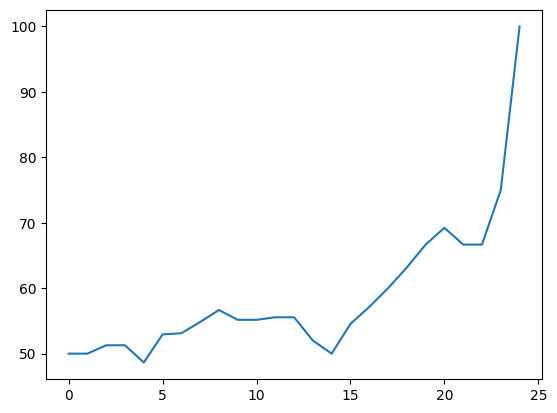

In [70]:
# thr = st.number_input("Reliability threshold", min_value=0, max_value=100, value=20, help="Select a threshold for the reliability of the prediction")
perc_list = []
for threshold in range(math.ceil((evaluation['Reliability of the forecast'].max()))):
    perc = evaluate_predictions(evaluation_df=evaluation, thr=threshold)[1]
    perc_list.append(perc)

plt.plot(perc_list);

In [80]:
import plotly.graph_objects as go

# Create a trace for the line plot
trace = go.Scatter(x=list(range(math.ceil((evaluation['Reliability of the forecast'].max())))), y=perc_list, mode='lines', name='Line Plot')
# Create a layout for the plot
layout = go.Layout(title='Interactive Line Plot', xaxis=dict(title='X-axis'), yaxis=dict(title='Y-axis'))
# Create a figure and add the trace to it
fig = go.Figure(data=[trace], layout=layout)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed